In [29]:
import numpy    as np
import xarray   as xr
import netCDF4 
import pandas as pd

## Modules for caculating statistics
from scipy   import stats, signal
from sklearn import linear_model

## Modules for plottings
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap, shiftgrid


plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figue_format = 'retina'

In [2]:
def read_var_GFDL(var_name,dir_name,exp_name,mod_name,year_str,year_end):
    file_name  =  "regrid_720x360_"+var_name+"."+str(year_str)+"-"+str(year_end)+"yr."+mod_name+"_"+exp_name+".nc"
    # file_name  =  var_name+"."+str(year_str)+"-"+str(year_end)+"yr."+mod_name+"_"+exp_name+".nc"    
    path_name  =  dir_name+file_name

    # Open the netCDF4 file
    f       = xr.open_dataset(path_name)
    var = f[var_name]    

    return var

In [3]:
def basemap_eck4( contour, axes, lat, lon, lon0 ):
    
    m = Basemap( projection = 'eck4', lon_0 = lon0, resolution = 'c' ,ax = axes)
    m.fillcontinents( color = 'grey', lake_color = 'grey', alpha = 0.1 )
    # m.drawcoastlines( linewidth = 0.15)
    m.drawmapboundary( fill_color = 'white')
    
    contour_shifted, lon_shifted = shiftgrid( lon0 + lon[0] + 180, contour, lon + 1e-5, start = False )
    
    lon_new, lat_new = np.meshgrid( lon_shifted, lat )
        
    x, y = m( lon_new, lat_new )
    
    # m.drawparallels( np.arange(-60.,61.,30.), labels = [1,0,0,0], color = 'grey' )
    # m.drawmeridians( np.arange(-180.,181.,60.), labels = [0,0,0,1], color = 'grey' )
    
    return m, x, y, contour_shifted

In [4]:
mask_lat = [-144.5, -90.25, -172, -172]
mask_lon = [50,-5,-56.3,-66.5]

In [5]:
color_name = ['red', 'lightsalmon', 'peru', 'orange', 'gold', 'yellow', 'olive', 
             'forestgreen', 'lime', 'cyan', 'deepskyblue' , 'royalblue', 'blueviolet',
             'purple', 'pink']

month_name = ["JAN","FEB","MAR","APR","MAY","JUN",
             "JUL","AUG","SEP","OCT","NOV","DEC"]

month_name_short = ["J","F","M","A","M","J",
                    "J","A","S","O","N","D"]

In [6]:
dir_name   =  "./DATA/MASKS/"
file_name  =  "mask_jfe_fert_GLOBAL.nc"
# file_name  =  "mask_zero.nc"
path_name  =  dir_name+file_name

mask_IF    = xr.open_dataset(path_name).jfe_fert#[0,:,:].rename({'grid_x_T': 'xh', 'grid_y_T': 'yh'})

In [8]:
["Southern Ocean","Atlantic Ocean","Pacific Ocean","Arctic Ocean","Indian Ocean"]

['Southern Ocean',
 'Atlantic Ocean',
 'Pacific Ocean',
 'Arctic Ocean',
 'Indian Ocean']

In [24]:
dir_name   =  "./DATA/MASKS/"
file_name  =  "regrid_720x360_ocean_static_no_mask_table.nc"
# file_name  =  "ocean_static_no_mask_table.nc"
path_name  =  dir_name+file_name

f         = xr.open_dataset(path_name)
basins    = xr.open_dataset(path_name).basin
# geolat    = xr.open_dataset(path_name).geolat
# geolon    = xr.open_dataset(path_name).geolon

In [10]:
dir_name   =  "./DATA/"
file_name  =  "regrid_720x360_PHY_LIMITATIONS_PP_WEIGHTED.nc"
# file_name  =  "PHY_LIMITATIONS_PP_WEIGHTED.nc"
path_name  =  dir_name+file_name

lim_phy    = xr.open_dataset(path_name).lim_phy

In [11]:
var_name = "rho"
year_str = 1990  ; year_end = 2014

exp_name   = "historical_D1_c5_control_B01"
mod_name   = "ESM4"
dir_name   = "/work/Kyungmin.Noh/DATA/GFDL_ESM4/1.IRON_FERTILIZATION/CONTROL/regrid/"
RHO   = read_var_GFDL(var_name,dir_name,exp_name,mod_name,
                           year_str,year_end)

In [12]:
var_name = "no3os"
year_str = 1990  ; year_end = 2014

exp_name   = "historical_D1_c5_control_B01"
mod_name   = "ESM4"
dir_name   = "/work/Kyungmin.Noh/DATA/GFDL_ESM4/1.IRON_FERTILIZATION/CONTROL/regrid/"
NO3_CTRL   = read_var_GFDL(var_name,dir_name,exp_name,mod_name,
                           year_str,year_end)

In [13]:
RHO_CLIM = RHO.mean("time")
NO3_CLIM = 1e+3*NO3_CTRL.mean("time")

In [14]:
lat = NO3_CLIM.lat  ; lon = NO3_CLIM.lon
# lat = NO3_CLIM.yh  ; lon = NO3_CLIM.xh

In [25]:
tmp_one   = NO3_CLIM/NO3_CLIM
Zone_SO_S = 1*tmp_one.where(NO3_CLIM>=1).where(lim_phy>=5).where(basins==1)\
                     #.where(RHO_CLIM>=26.75).where(lat<=-30)


In [46]:
tmp_one   = NO3_CLIM/NO3_CLIM
Zone_GO   = 0*tmp_one.where(basins!=0)
Zone_SO_S = 1*tmp_one.where(NO3_CLIM>=1).where(lim_phy>=5).where(basins==1)\
                     .where(RHO_CLIM>=26.75).where(lat<=-30)
Zone_SO_N = 2*tmp_one.where(NO3_CLIM>=1).where(lim_phy>=5).where(basins==1)\
                     .where(RHO_CLIM<=26.75).where(lat>=-60.5)
Zone_EP   = 3*tmp_one.where(NO3_CLIM>=1).where(lim_phy>=5).where(basins==3)\
                     .where((lat<=20) & (lat>=-37)).where(lon>=-230)
Zone_NP   = 4*tmp_one.where(NO3_CLIM>=1).where(lim_phy>=5).where(basins==3)\
                     .where((lat<=65) & (lat>=30)).where(lon>=-225)

Zones = xr.concat([Zone_GO,2*Zone_SO_S,2*Zone_SO_N,2*Zone_EP,2*Zone_NP],dim="Zones")\
        .mean("Zones")
Zones = xr.concat([Zone_GO,Zone_SO_S,Zone_SO_N/2,Zone_EP/3,Zone_NP/4],dim="Zones")\
        .mean("Zones")

In [19]:
tmp_zone = Zone_SO_S
mask_IF[0,:,:] = (tmp_zone/tmp_zone).where(~tmp_zone.isnull(),0).values

In [27]:
ds = xr.Dataset(    
                   {
                        "jfe_fert":     (("time","grid_y_T","grid_x_T"), mask_IF.values),
                   },

                    coords={
                                "grid_x_T": mask_IF.grid_x_T,
                                "grid_y_T": mask_IF.grid_y_T,
                                "time":mask_IF.time.assign_attrs(calendar = "NOLEAP",
                                                            calendar_type = "NOLEAP",
                                                            modulo= " ",
                                                            units = "days since 1900-12-31 18:00:00")

                           }
                )

ds['time'] = ds['time'].astype('float')

dir_name  = "./DATA/MASKS/"
file_name = "tmp_mask.nc" 
ds.to_netcdf(dir_name+file_name,unlimited_dims='time')

In [47]:
ds = xr.Dataset(    
                   {
                        "jfe_fert":     (("lat","lon"), Zones.values),
                   },

                    coords={
                                "lat": Zones.lat.values,
                                "lon": Zones.lon.values,
                           }
                )

dir_name  = "./DATA/MASKS/"
file_name = "regrid_720x360_mask_LS_jfe_fert_one.nc" 
ds.to_netcdf(dir_name+file_name,unlimited_dims='time')

[Text(1, 0.5, 'SO(S)'),
 Text(1, 1.5, 'SO(N)'),
 Text(1, 2.5, 'EP'),
 Text(1, 3.5, 'NP')]

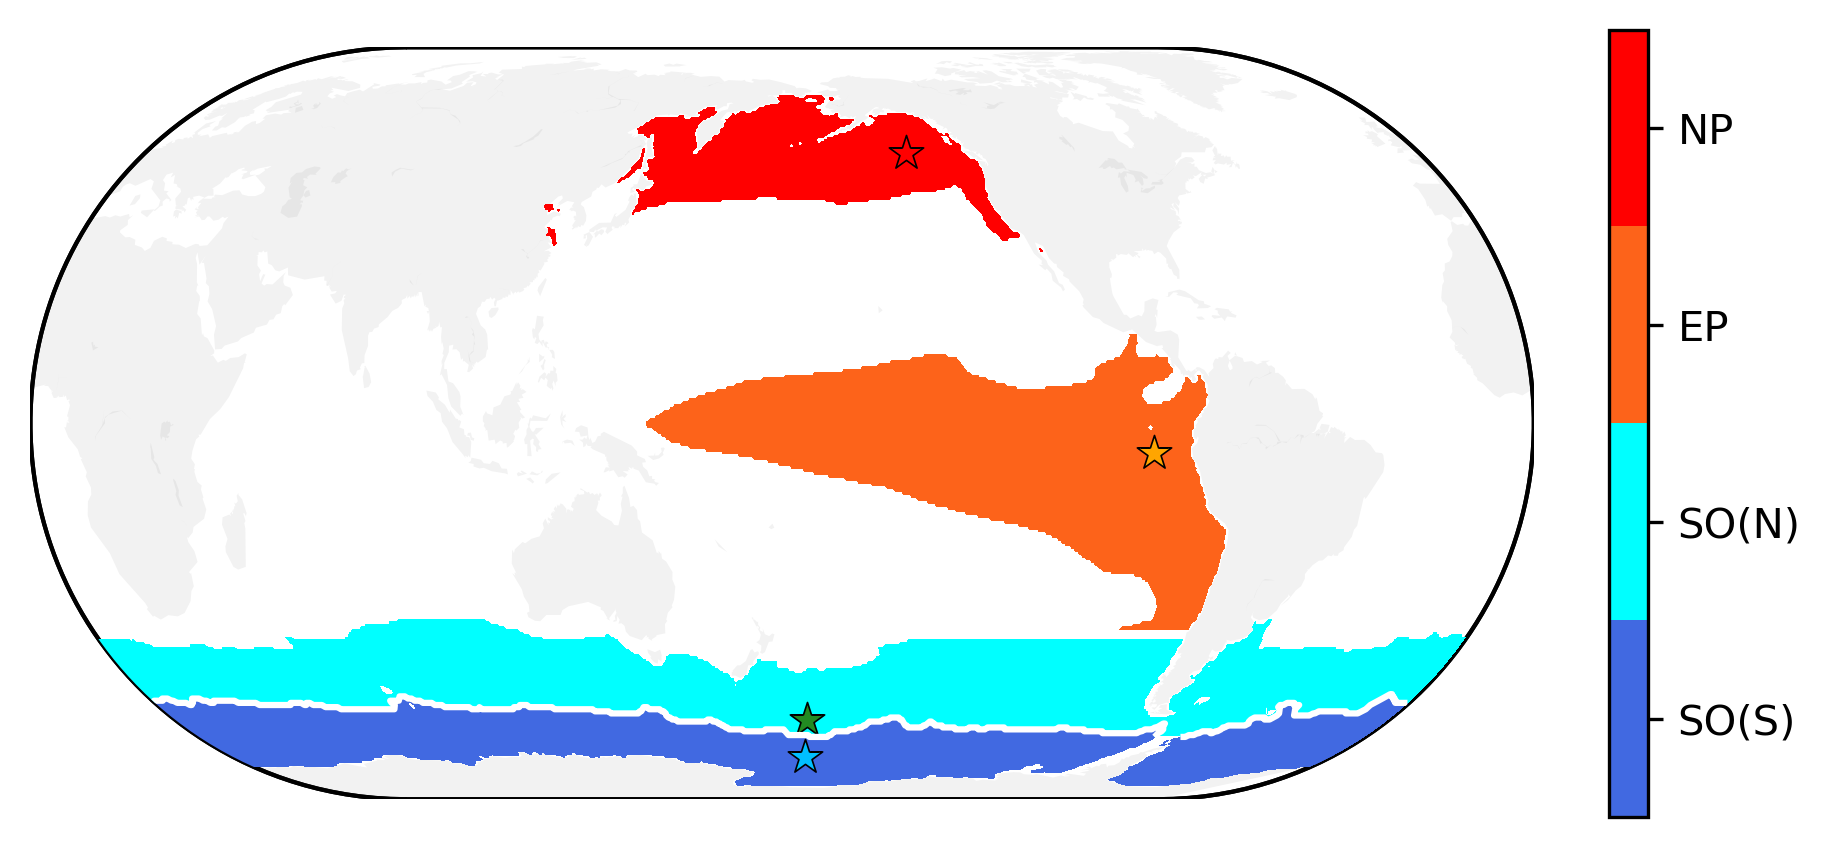

In [30]:
fig, axes = plt.subplots(1,1,figsize=(6,3),constrained_layout=True)

lon0 = -179.5

#######################################################################################
####   Global Map of Phytoplankton Limitations
######################################################################################
tmp_var = Zones
m, x, y, contour = basemap_eck4( tmp_var, axes, tmp_var.lat.values, 
                                            tmp_var.lon.values, lon0)

contour_var      = m.contourf(x,y,contour,levels=[0,1,2,3,4],alpha=1.0,
                              colors=['royalblue','cyan','#fd631a','red'],)
contour_line     = m.contour(x,y,contour,[1,2,3,4,5],colors='w')


tmp_x = mask_lon ; tmp_y = mask_lat
x,y = m(tmp_y,tmp_x)

for ind_mask in range(4):
    m.scatter(x[ind_mask],y[ind_mask],color=color_name[int(3.6*ind_mask)],
              s=75,marker='*',alpha=1.0,edgecolor='black',linewidths=0.4)

cb = fig.colorbar(contour_var,ax=axes,location='right', shrink=0.9)
cb.set_ticks([0.5,1.5,2.5,3.5])
cb.ax.set_yticklabels(["SO(S)","SO(N)","EP","NP"])    

In [44]:
def convert_area(var):   
    R = 6.361e+6                            ## Radius of Earth [m]
    weights      = np.cos(np.deg2rad(var.lat))
    weights.name = "weights"    
    dx = var.lon[1] - var.lon[0] ## Degree
    dy = var.lat[1] - var.lat[0] ## Degree   
    
    var_weighted = var.weighted(weights).sum(("lat","lon"))\
                    *(R * np.pi/180)**2 * dx * dy
    
    return var_weighted

In [45]:
area_GLOBAL   = convert_area(tmp_one)
area_NP       = convert_area(Zone_NP)
area_EP       = convert_area(Zone_EP)
area_SO_N     = convert_area(Zone_SO_N)
area_SO_S     = convert_area(Zone_SO_S)

print("{:4.2f}".format(area_NP/area_GLOBAL.values*100))
print("{:4.2f}".format(area_EP/area_GLOBAL.values*100))
print("{:4.2f}".format(area_SO_N/area_GLOBAL.values*100))
print("{:4.2f}".format(area_SO_S/area_GLOBAL.values*100))

16.22
32.94
26.68
8.60


In [69]:
area_tmp     = convert_area(basins==0)

m2_to_km2 = (1e+3)**2
million   = 1e+6
(area_tmp)/million/m2_to_km2

<xarray.DataArray ()>
array(153.24268203)